## 0. This is my model to solve the steak sushi pizza dataset

### import libraries

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import pandas as pd
import matplotlib.pyplot as plt

import os
import requests
import zipfile
from pathlib import Path
import shutil
from tqdm.auto import tqdm

### Constants

In [2]:
# Device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

NUM_EPOCHS = 10
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [3]:
!nvidia-smi

Wed Dec 14 05:06:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    48W / 400W |      3MiB / 40536MiB |     25%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get Data

In [4]:

# Setup path to a data folder
data_path = Path("data/")
train_dir = data_path / "train"
test_dir = data_path / "test"


train_dir, test_dir


(PosixPath('data/train'), PosixPath('data/test'))

## 2. Process Data


### 2.1 Create data transform

In [5]:
# Create training transform with TrivialAugment
train_transform = transforms.Compose([
                                      transforms.Resize(size=(224,224)),
                                      # transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([
                                    transforms.Resize(size=(224,224)),
                                    transforms.ToTensor()
])


### 2.2 Create Dataset from `torchvision.datasets.Food101`

In [6]:
# Get DataSet From Food101

if train_dir.is_dir():
  print(f"Dataset is already downloaded")
else:
  train_data = datasets.Food101(root=train_dir,
                                split= "train",
                                transform=train_transform, # a transform for the  data
                                target_transform=None,
                                download=True)
  
if test_dir.is_dir():
  print(f"Dataset is already downloaded")
else:                            
  test_data =  datasets.Food101(root=test_dir,
                                split="test",
                                transform=test_transform, # a transform for the  data
                                target_transform=None,
                                download=True)


  0%|          | 0/4996278331 [00:00<?, ?it/s]

Extracting data/train/food-101.tar.gz to data/train


  0%|          | 0/4996278331 [00:00<?, ?it/s]

Extracting data/test/food-101.tar.gz to data/test


In [7]:
# Work on a few classes first instead of all 101 so we remove all the other classes
targets_to_keep = ["pizza","steak","sushi"]

if (train_dir / "food-101").is_dir():
  for dirpath, dirnames, filenames in os.walk(train_dir / "food-101/images"):
    label = dirpath.split("/")[-1]
    if label in targets_to_keep: 
      shutil.move(dirpath, train_dir)
    elif label != "images":
      shutil.rmtree(dirpath)
  shutil.rmtree(train_dir / "food-101")
  os.remove(train_dir / "food-101.tar.gz")
else:
  print(f"{train_dir}/food-101 already purged")   

if (test_dir / "food-101").is_dir():
  for dirpath, dirnames, filenames in os.walk(test_dir / "food-101/images"):
    label = dirpath.split("/")[-1]
    if label in targets_to_keep: 
      shutil.move(dirpath, test_dir)
    elif label != "images":
      shutil.rmtree(dirpath)
  shutil.rmtree(test_dir / "food-101")
  os.remove(test_dir / "food-101.tar.gz")
else:
  print(f"{test_dir}/food-101 already purged")   

In [8]:
# Put the New data in
train_data = datasets.ImageFolder(root=train_dir,
                                transform=train_transform, # a transform for the  data
                                target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                transform=test_transform, # a transform for the  data
                                target_transform=None)

In [9]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 2.3 Create DataLoader

In [10]:
# Turn train and test datasets into DataLoader's
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers= NUM_WORKERS,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers= NUM_WORKERS,
                             shuffle=False) 



## 3. Create a Model

In [11]:
class TinyAce(nn.Module):
  """
  Model architecture copying tiny VGG grom CNN Explainer
  """
  def __init__(self, input_shape:int,
                hidden_units:int,
                output_shape: int)-> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier= nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*56*56, out_features=output_shape)
    )
  def forward(self,x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [12]:
torch.manual_seed(42)
model_0 = TinyAce(input_shape=3,
                  hidden_units=32,
                  output_shape=len(class_names)).to(device)


In [13]:
# Get a single image batch
image_batch,label_batch = next(iter(train_dataloader))
image_batch.shape,label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [14]:
model_0(image_batch.to(device))

tensor([[ 0.0202,  0.0088, -0.0088],
        [ 0.0186,  0.0036, -0.0101],
        [ 0.0207,  0.0081, -0.0093],
        [ 0.0184,  0.0074, -0.0094],
        [ 0.0203,  0.0041, -0.0093],
        [ 0.0173,  0.0063, -0.0095],
        [ 0.0186,  0.0040, -0.0101],
        [ 0.0182,  0.0051, -0.0070],
        [ 0.0189,  0.0037, -0.0097],
        [ 0.0173,  0.0072, -0.0090],
        [ 0.0185,  0.0086, -0.0098],
        [ 0.0207,  0.0004, -0.0113],
        [ 0.0201,  0.0071, -0.0091],
        [ 0.0176,  0.0087, -0.0059],
        [ 0.0181,  0.0080, -0.0104],
        [ 0.0187,  0.0064, -0.0068],
        [ 0.0197,  0.0057, -0.0084],
        [ 0.0178,  0.0046, -0.0081],
        [ 0.0217,  0.0096, -0.0095],
        [ 0.0202,  0.0056, -0.0074],
        [ 0.0221,  0.0080, -0.0098],
        [ 0.0209,  0.0097, -0.0088],
        [ 0.0159,  0.0077, -0.0092],
        [ 0.0203,  0.0046, -0.0110],
        [ 0.0205,  0.0055, -0.0104],
        [ 0.0178,  0.0008, -0.0100],
        [ 0.0191,  0.0079, -0.0097],
 

## 4. Train the model


In [15]:
# Create train_step()
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [16]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  # Put model in eval mode
  model.eval()

  #Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    #loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X,y = X.to(device),y.to(device)
      # 1. Forwar pass 
      test_pred_logits = model(X)
                               
      # 2. Calculate the loss 
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()
      
      # calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

    # Adjusts metrics to get average loss and accuracy per batch

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [17]:
#1.Create a train function that takes in various model parameters +optimizer + dataloaders + loss functions
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device
          ):
  
  # 2. create empty results dictionary
  results={"train_loss":[],
           "train_acc":[],
           "test_loss":[],
           "test_acc":[]}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc: .4f} | Test loss {test_loss:.4f} | Test  acc: {test_acc: .4f} ") 

    # 5. Updates results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
  
  # 6. Return the filled results at the end of the epochs
  return results

In [18]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001) 

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
      train_dataloader = train_dataloader,
      test_dataloader= test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time {end_time - start_time: .3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.9492 | Train acc:  0.5508 | Test loss 0.8222 | Test  acc:  0.6356 
Epoch: 1 | Train loss: 0.8174 | Train acc:  0.6375 | Test loss 0.9185 | Test  acc:  0.5170 
Epoch: 2 | Train loss: 0.7779 | Train acc:  0.6703 | Test loss 0.6679 | Test  acc:  0.7281 
Epoch: 3 | Train loss: 0.7124 | Train acc:  0.7056 | Test loss 0.6476 | Test  acc:  0.7364 
Epoch: 4 | Train loss: 0.6239 | Train acc:  0.7462 | Test loss 0.5012 | Test  acc:  0.8379 
Epoch: 5 | Train loss: 0.4882 | Train acc:  0.8062 | Test loss 0.3632 | Test  acc:  0.8769 
Epoch: 6 | Train loss: 0.3316 | Train acc:  0.8733 | Test loss 0.2303 | Test  acc:  0.9176 
Epoch: 7 | Train loss: 0.1827 | Train acc:  0.9392 | Test loss 0.0777 | Test  acc:  0.9806 
Epoch: 8 | Train loss: 0.0744 | Train acc:  0.9792 | Test loss 0.0304 | Test  acc:  0.9907 
Epoch: 9 | Train loss: 0.0521 | Train acc:  0.9819 | Test loss 0.0384 | Test  acc:  0.9873 
Total training time  75.485 seconds


In [19]:
model_0_results

{'train_loss': [0.9491658090276921,
  0.8173625190207299,
  0.7779415300551881,
  0.7123577534518344,
  0.6239413977303403,
  0.48822545069963375,
  0.33164296441889823,
  0.18268103901534638,
  0.07444927684883489,
  0.05207837797562651],
 'train_acc': [0.5507535460992908,
  0.6375221631205674,
  0.6703235815602837,
  0.7055629432624114,
  0.746232269503546,
  0.8061835106382979,
  0.8733377659574468,
  0.9391622340425532,
  0.9791666666666667,
  0.9819370567375886],
 'test_loss': [0.822219082649718,
  0.9185046081213241,
  0.6679367045772836,
  0.6475590461112083,
  0.5012132119625172,
  0.36317027344348585,
  0.23029085296265622,
  0.07766455437670997,
  0.030400553824716903,
  0.038377289137644495],
 'test_acc': [0.6356382978723404,
  0.5169547872340425,
  0.7280585106382979,
  0.7363696808510638,
  0.8378767730496455,
  0.8768838652482269,
  0.9175531914893617,
  0.980607269503546,
  0.9906914893617021,
  0.9872562056737588]}

### Create model with data augmentation

In [20]:
# Create training transform with TrivialAugment
train_transform_trivial = transforms.Compose([
                                      transforms.Resize(size=(224,224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([
                                    transforms.Resize(size=(224,224)),
                                    transforms.ToTensor()
])

In [21]:
# Put the New data in
train_data_trivial = datasets.ImageFolder(root=train_dir,
                                transform=train_transform_trivial, # a transform for the  data
                                target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                transform=test_transform, # a transform for the  data
                                target_transform=None)

In [22]:
# Turn train and test datasets into DataLoader's
train_dataloader_trivial = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers= NUM_WORKERS,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers= NUM_WORKERS,
                             shuffle=False)

In [23]:
torch.manual_seed(42)
model_1 = TinyAce(input_shape=3,
                  hidden_units=32,
                  output_shape=len(class_names)).to(device)

In [24]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001) 

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_1_results = train(model=model_1,
      train_dataloader = train_dataloader_trivial,
      test_dataloader= test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time {end_time - start_time: .3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.9483 | Train acc:  0.5470 | Test loss 0.8152 | Test  acc:  0.6398 
Epoch: 1 | Train loss: 0.8081 | Train acc:  0.6436 | Test loss 0.8348 | Test  acc:  0.6086 
Epoch: 2 | Train loss: 0.7562 | Train acc:  0.6786 | Test loss 0.6615 | Test  acc:  0.7282 
Epoch: 3 | Train loss: 0.6951 | Train acc:  0.7073 | Test loss 0.5946 | Test  acc:  0.7569 
Epoch: 4 | Train loss: 0.6059 | Train acc:  0.7554 | Test loss 0.4668 | Test  acc:  0.8391 
Epoch: 5 | Train loss: 0.4764 | Train acc:  0.8244 | Test loss 0.3440 | Test  acc:  0.8922 
Epoch: 6 | Train loss: 0.3309 | Train acc:  0.8749 | Test loss 0.2884 | Test  acc:  0.8952 
Epoch: 7 | Train loss: 0.1924 | Train acc:  0.9357 | Test loss 0.0671 | Test  acc:  0.9849 
Epoch: 8 | Train loss: 0.1078 | Train acc:  0.9628 | Test loss 0.0481 | Test  acc:  0.9880 
Epoch: 9 | Train loss: 0.0345 | Train acc:  0.9900 | Test loss 0.0357 | Test  acc:  0.9904 
Total training time  75.044 seconds


In [25]:
class TinyAce10(nn.Module):
  """
  Model architecture copying tiny VGG grom CNN Explainer
  """
  def __init__(self, input_shape:int,
                hidden_units:int,
                output_shape: int)-> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3,stride=1,padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier= nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*56*56, out_features=output_shape)
    )
  def forward(self,x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [26]:
torch.manual_seed(42)
model_2 = TinyAce10(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

In [27]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(),
                             lr=0.001) 

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_2_results = train(model=model_2,
      train_dataloader = train_dataloader,
      test_dataloader= test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time {end_time - start_time: .3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0531 | Train acc:  0.4566 | Test loss 0.9111 | Test  acc:  0.5642 
Epoch: 1 | Train loss: 0.8834 | Train acc:  0.5911 | Test loss 0.9294 | Test  acc:  0.5683 
Epoch: 2 | Train loss: 0.8536 | Train acc:  0.6118 | Test loss 0.8107 | Test  acc:  0.6348 
Epoch: 3 | Train loss: 0.8161 | Train acc:  0.6343 | Test loss 0.8014 | Test  acc:  0.6490 
Epoch: 4 | Train loss: 0.7980 | Train acc:  0.6516 | Test loss 0.7354 | Test  acc:  0.6975 
Epoch: 5 | Train loss: 0.7512 | Train acc:  0.6728 | Test loss 0.6949 | Test  acc:  0.7041 
Epoch: 6 | Train loss: 0.6845 | Train acc:  0.7181 | Test loss 0.6171 | Test  acc:  0.7569 
Epoch: 7 | Train loss: 0.6006 | Train acc:  0.7631 | Test loss 0.4780 | Test  acc:  0.8406 
Epoch: 8 | Train loss: 0.4765 | Train acc:  0.8167 | Test loss 0.3438 | Test  acc:  0.8811 
Epoch: 9 | Train loss: 0.3670 | Train acc:  0.8563 | Test loss 0.3328 | Test  acc:  0.8785 
Total training time  73.239 seconds


### Plot loss curves

In [28]:
def plot_loss_curves(results):
  """Plots training curves of a results dictionary"""
  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracry values of the results dicitonary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # figure out how amny epochs there were 
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label = "train_acc")
  plt.plot(epochs, test_accuracy, label = "test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

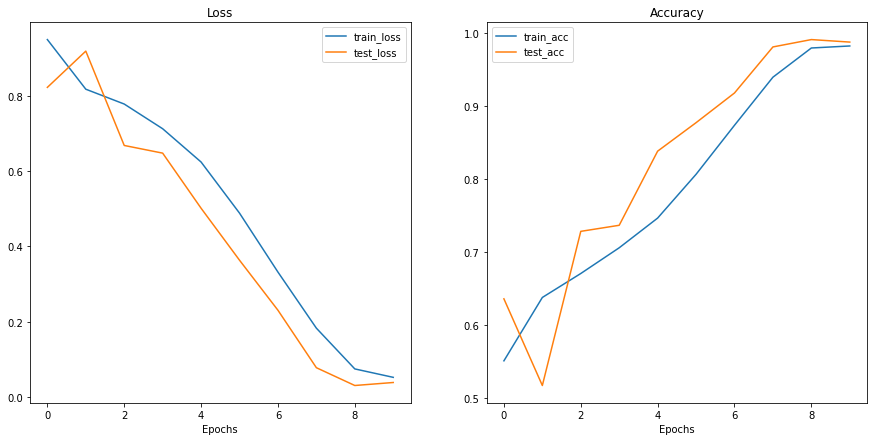

In [29]:
print()
plot_loss_curves(model_0_results)

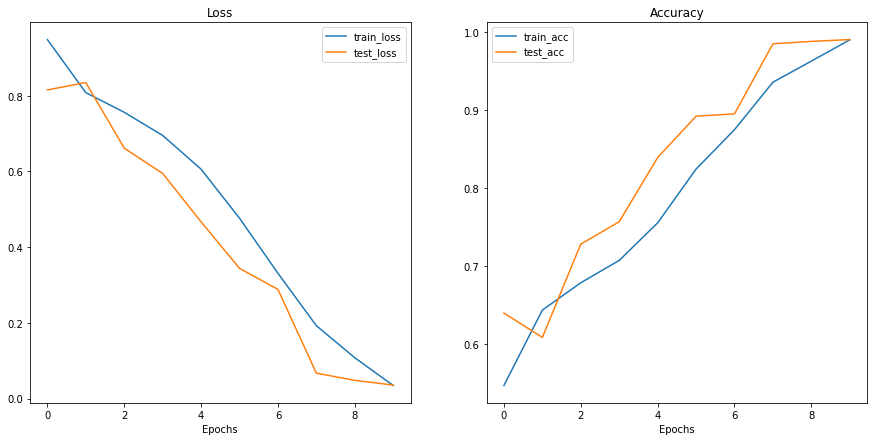

In [30]:
plot_loss_curves(model_1_results)

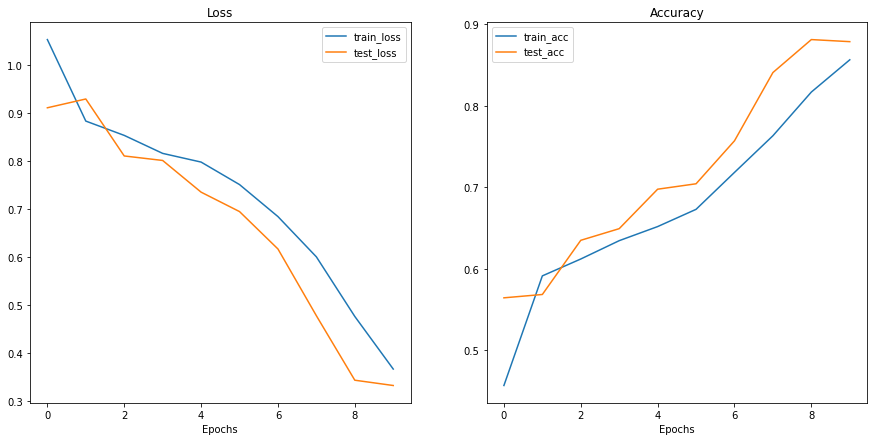

In [31]:
plot_loss_curves(model_2_results)

## Model 0 with `32 hidden units and no Data Augmentation` out performs Model 1 and Model 2

Saving all models

In [32]:
from pathlib import Path

# Create model directory path
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "10_hidden_No_Data_Augmentation_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),f= MODEL_SAVE_PATH)


Saving model to: models/10_hidden_No_Data_Augmentation_model.pth
